<a href="https://colab.research.google.com/github/jasperamaralapudi/AI-ML1/blob/main/frauddetectioninbankpayments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Necessary imports

## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
# read the data and show first 5 rows
data = pd.read_csv("/content/bs140513_032310.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12974 entries, 0 to 12973
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   step         12974 non-null  int64  
 1   customer     12974 non-null  object 
 2   age          12974 non-null  object 
 3   gender       12974 non-null  object 
 4   zipcodeOri   12974 non-null  object 
 5   merchant     12974 non-null  object 
 6   zipMerchant  12974 non-null  object 
 7   category     12974 non-null  object 
 8   amount       12974 non-null  float64
 9   fraud        12974 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1013.7+ KB


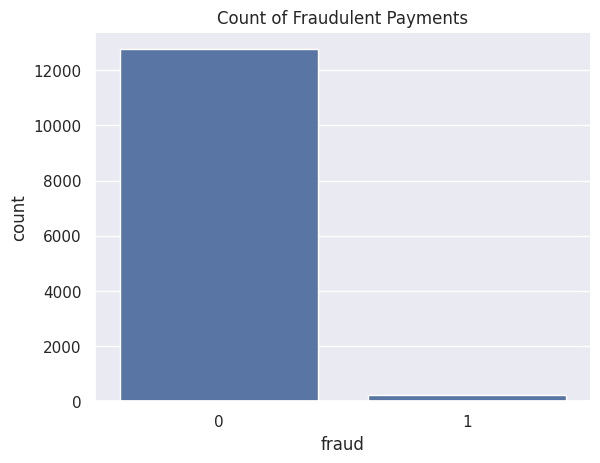

Number of normal examples:  12760
Number of fradulent examples:  214


In [4]:
# Create two dataframes with fraud and non-fraud data
df_fraud = data.loc[data.fraud == 1]
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())

In [6]:
print("Mean feature values per category",data.groupby('category')[['amount','fraud']].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    44.091372  0.014440
'es_contents'              47.364000  0.000000
'es_fashion'               62.374364  0.024242
'es_food'                  35.480000  0.000000
'es_health'               167.763161  0.167742
'es_home'                 181.133500  0.233333
'es_hotelservices'        132.947843  0.156863
'es_hyper'                 42.918860  0.014706
'es_leisure'              297.165455  0.909091
'es_otherservices'        120.463654  0.192308
'es_sportsandtoys'        186.860229  0.412214
'es_tech'                 122.175303  0.060606
'es_transportation'        27.108064  0.000000
'es_travel'              2133.856667  0.583333
'es_wellnessandbeauty'     73.280304  0.071823


In [7]:
# Create two dataframes with fraud and non-fraud data
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,27.108064,0.000000
'es_food',NaN,35.480000,0.000000
'es_hyper',122.632500,41.729104,1.470588
'es_barsandrestaurants',190.047500,41.952821,1.444043
'es_contents',NaN,47.364000,0.000000
'es_fashion',197.710000,59.011988,2.424242
'es_wellnessandbeauty',251.349615,59.501131,7.182320
'es_sportsandtoys',348.130370,73.761688,41.221374
'es_otherservices',292.552000,79.490238,19.230769


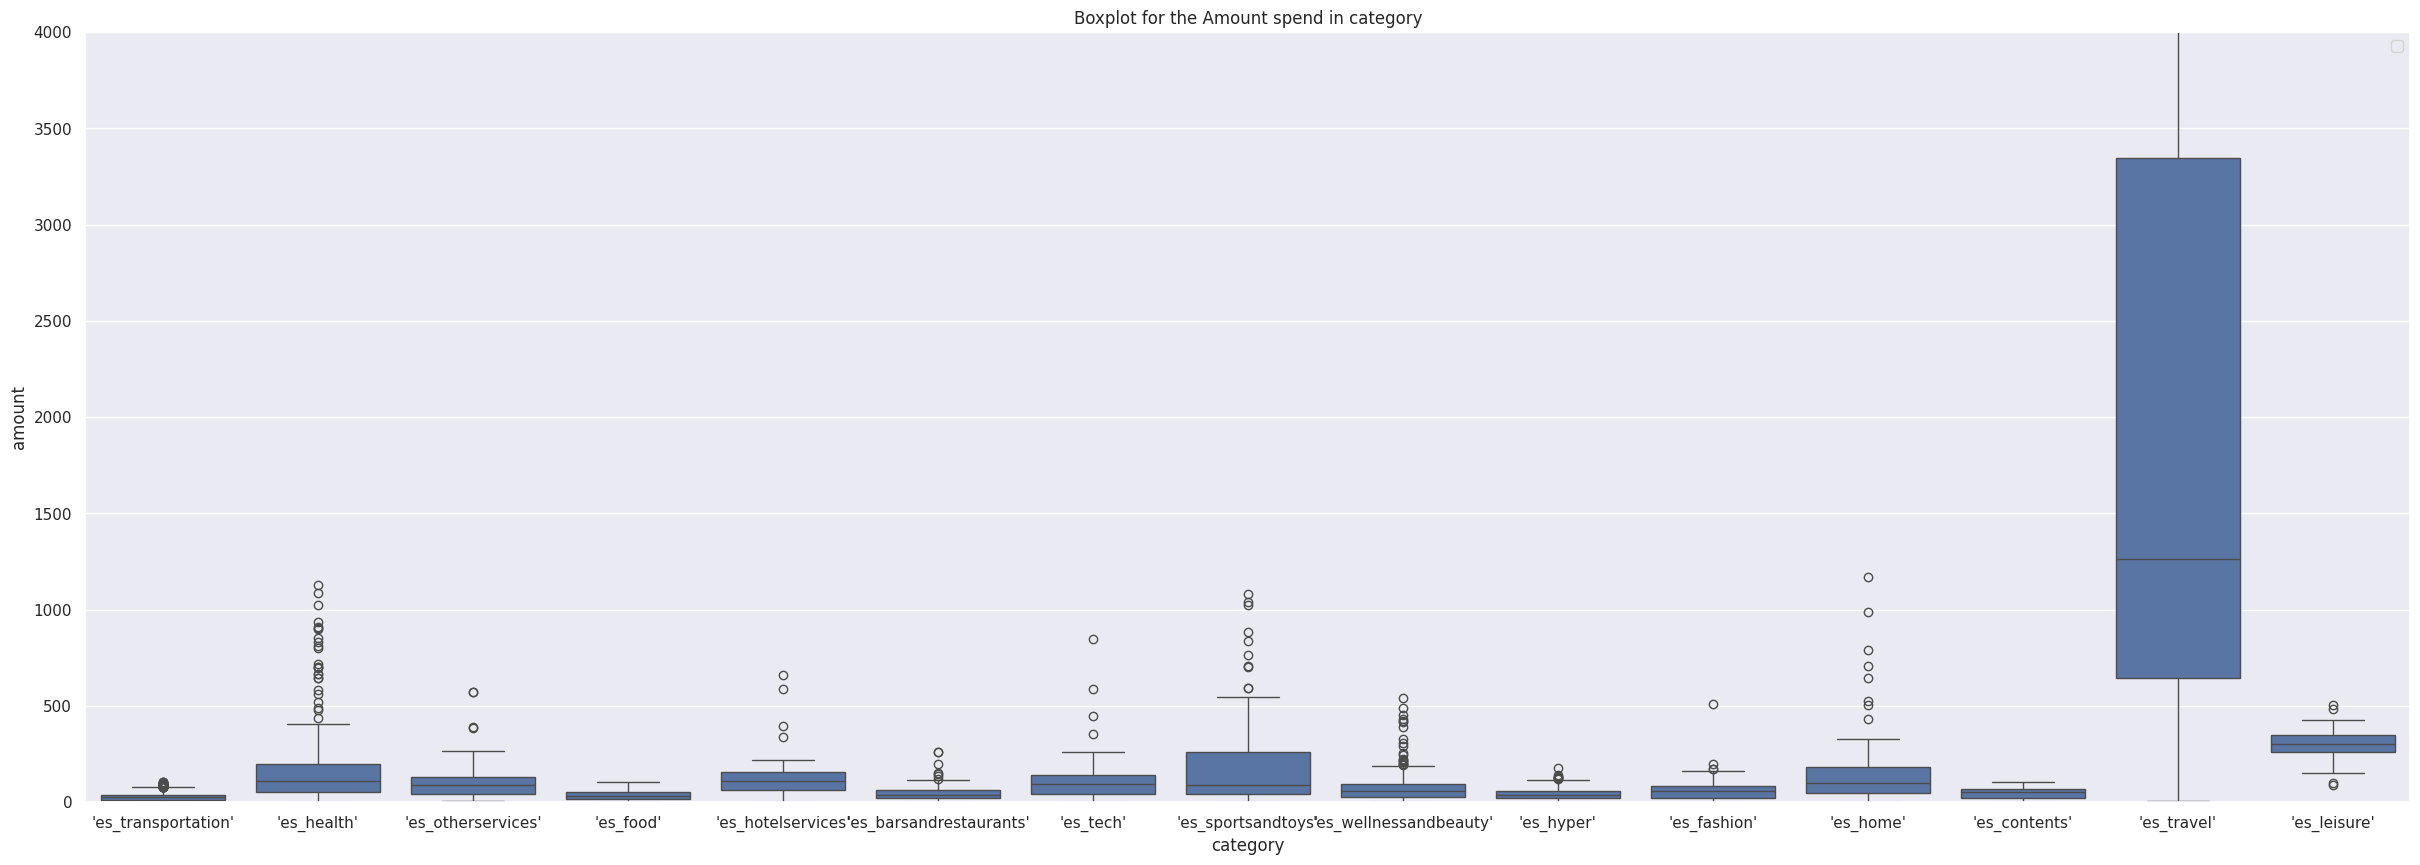

In [8]:
# Plot histograms of the amounts in fraud and non-fraud data
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

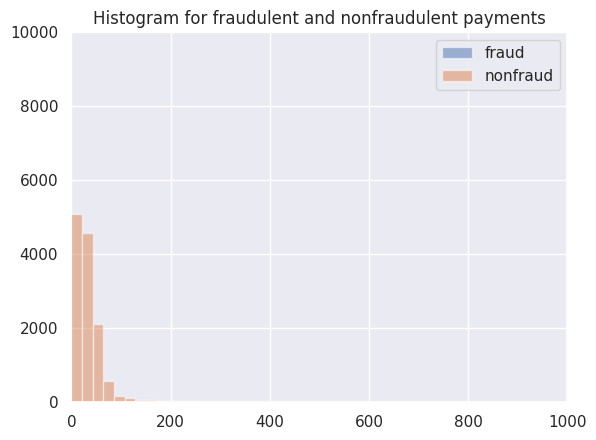

In [9]:
# Plot histograms of the amounts in fraud and non-fraud data
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [10]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.000000
2  '2'       1.239368
4  '4'       1.379310
1  '1'       1.520913
5  '5'       1.830986
3  '3'       2.025316
6  '6'       3.304348
0  '0'       4.081633


In [11]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [12]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [13]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,159,4,2,27,12,4.55,0
1,0,2077,2,2,27,12,39.68,0
2,0,1720,4,1,15,12,26.89,0
3,0,1233,3,2,27,12,17.25,0
4,0,2699,5,2,27,12,35.72,0


In [14]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       159    4       2        27        12    4.55
1     0      2077    2       2        27        12   39.68
2     0      1720    4       1        15        12   26.89
3     0      1233    3       2        27        12   17.25
4     0      2699    5       2        27        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


Oversampling with SMOTE

In [17]:
# Add column names to the y_res DataFrame
y_res.columns = ['fraud']

# Print the value counts of the 'fraud' column
print(y_res['fraud'].value_counts())

fraud
0    12760
1    12760
Name: count, dtype: int64


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [20]:
# Function for plotting ROC_AUC curve

def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [21]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ",
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.35054724834283


**K-Neighbours Classifier**

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      3828
           1       0.97      0.99      0.98      3828

    accuracy                           0.98      7656
   macro avg       0.98      0.98      0.98      7656
weighted avg       0.98      0.98      0.98      7656

Confusion Matrix of K-Nearest Neigbours: 
 [[3694  134]
 [  25 3803]]


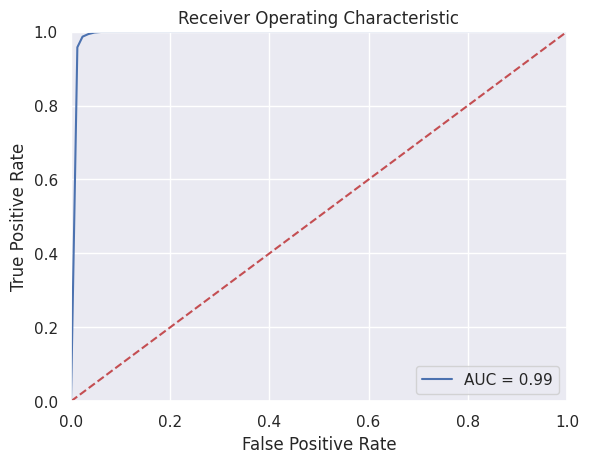

In [22]:
# %% K-ello Neigbors

knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

**Random Forest Classifier**

<ipython-input-23-e57e8f380b47>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train,y_train)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      3828
           1       0.97      1.00      0.98      3828

    accuracy                           0.98      7656
   macro avg       0.98      0.98      0.98      7656
weighted avg       0.98      0.98      0.98      7656

Confusion Matrix of Random Forest Classifier: 
 [[3720  108]
 [  15 3813]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


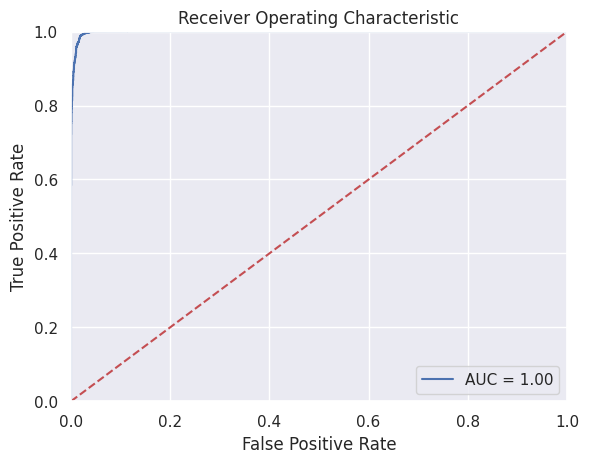

In [23]:
# %% Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

**XGBoost Classifier**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:53:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3828
           1       0.99      1.00      0.99      3828

    accuracy                           0.99      7656
   macro avg       0.99      0.99      0.99      7656
weighted avg       0.99      0.99      0.99      7656

Confusion Matrix of XGBoost: 
 [[3793   35]
 [   8 3820]]


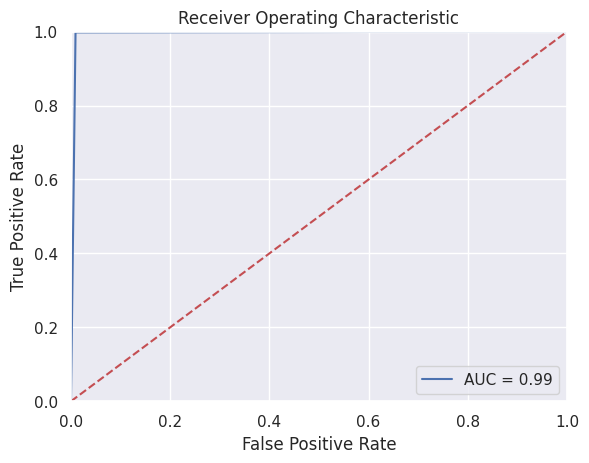

In [25]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400,
                                objective="binary:hinge", booster='gbtree',
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0,
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1,
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])
